In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import tensorflow as tf
import os

from matplotlib import pyplot as plt
from scipy.special import erf
from typing import Union 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Dropout, Concatenate, Reshape
from tqdm import tqdm

2024-06-02 23:14:50.456563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Simulated Flares
class_info = pd.read_csv('sim3/simulated_flares.csv')
ids = [i for i in class_info['identifier']]
peak_count = [int(count) for count in class_info['peak_count']]

data = []
labels = []

for i in ids:
    tod = pd.read_csv('sim3/flares/' + f'{i}' + '.csv')
    data.append(list(tod['Counts']))
    
for index in range(len(class_info)):
    if str(class_info['flare_type'][index]) == 'A':
        labels.append(0)
    if str(class_info['flare_type'][index]) == 'B':
        labels.append(1)
    else:
        continue
data = pad_sequences(data, padding='post', dtype=float)

In [3]:
# Derivative of the light curve
data_deriv = [ (data[i][1:] - data[i][:-1]) for i in range(len(data)) ] 

data_deriv = pad_sequences(data_deriv, padding='post', dtype=float)

print(data_deriv[0])
print(data_deriv.shape)
print(type(data_deriv[0, 0]))

[-0.00328779 -0.00327313 -0.00325786 ...  0.          0.
  0.        ]
(1000, 1998)
<class 'numpy.float64'>


In [4]:
model1 = Sequential()
    
# First convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data[0]), 1)))
model1.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model1.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

# Flatten the output
model1.add(Flatten())

# Fully connected layer
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model1.fit(np.array(data), np.array(labels), epochs=100, batch_size=32, validation_split=0.2, verbose=1)


model2 = Sequential()

# First convolutional layer
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data_deriv[0]), 1)))
model2.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model2.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

# Flatten the output
model2.add(Flatten())

# Fully connected layer
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

# Output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(np.array(data_deriv), np.array(labels), epochs=100, batch_size=32, validation_split=0.2, verbose=1)

2024-06-02 23:14:57.698167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


Epoch 1/100


2024-06-02 23:15:00.057602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-02 23:15:00.744044: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ca7716fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-02 23:15:00.744096: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-06-02 23:15:00.754147: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 23:15:01.007961: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 6s 28ms/step - loss: 61.8653 - accuracy: 0.5362 - val_loss: 2.4925 - val_accuracy: 0.5200
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 0.7720 - accuracy: 0.6850 - val_loss: 0.6904 - val_accuracy: 0.6800
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.5610 - accuracy: 0.7487 - val_loss: 0.6057 - val_accuracy: 0.7100
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 0.4706 - accuracy: 0.7925 - val_loss: 0.5843 - val_accuracy: 0.7300
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 0.4156 - accuracy: 0.8200 - val_loss: 0.5717 - val_accuracy: 0.7400
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 0.4717 - accuracy: 0.8163 - val_loss: 0.5711 - val_accuracy: 0.7800
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 0.3684 - accuracy: 0.8325 - val_loss: 1.0589 - val_accuracy: 0.6850
Epoch 8/100
25/25

In [5]:
# Concatenate the outputs of the two models
merged = Concatenate()([model1.output, model2.output])

# Add more layers 
x = Dense(64, activation='relu')(merged)
final_output = Dense(1, activation='sigmoid')(x)

autoencoder = Model(inputs=[model1.input, model2.input], outputs=final_output)

# Compile the model
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.fit([data, data_deriv], np.array(labels), epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 5s 21ms/step - loss: 0.6698 - accuracy: 0.4770
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5964 - accuracy: 0.5400
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5418 - accuracy: 0.8780
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.4927 - accuracy: 0.9470
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.4623 - accuracy: 0.9320
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 0.4240 - accuracy: 0.9410
Epoch 7/100
32/32 [==============================] - 1s 19ms/step - loss: 0.4130 - accuracy: 0.9260
Epoch 8/100
32/32 [==============================] - 1s 19ms/step - loss: 0.3882 - accuracy: 0.9240
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 0.3692 - accuracy: 0.9210
Epoch 10/100
32/32 [==============================] - 1s 18ms/step - loss: 0.3541 - accuracy: 0.9120

In [6]:
# Anomaly Detection of Processed Flares
norminfo = pd.read_csv('allflares_processed.csv')
idsnorm = [i for i in norminfo['identifier']]
peak_count = [int(count) for count in norminfo['peak_count']]

datanorm = []
labelsnorm = []

for i in idsnorm:
    tod = pd.read_csv('flares/' + f'{i}' + '.csv')
    datanorm.append(list(tod['Counts']))
    
for index in range(len(norminfo)):
    if str(norminfo['flare_type'][index]) == 'A':
        labelsnorm.append(0)
    if str(norminfo['flare_type'][index]) == 'B':
        labelsnorm.append(1)
    else:
        continue
datanorm = pad_sequences(datanorm, padding='post', dtype=float, maxlen=1999)

datanorm_deriv = [ (datanorm[i][1:] - datanorm[i][:-1]) for i in range(len(datanorm)) ] 
datanorm_deriv = pad_sequences(datanorm_deriv, padding='post', dtype=float)
print(datanorm.shape)
print(datanorm_deriv.shape)
print(type(datanorm_deriv[0,0]))

(1091, 1999)
(1091, 1998)
<class 'numpy.float64'>


In [7]:
datanorm_expanded = np.expand_dims(datanorm, axis=-1)
datanorm_deriv_expanded = np.expand_dims(datanorm_deriv, axis=-1)

# Use the autoencoder to reconstruct the inputs based on model data
recondata = autoencoder.predict([datanorm_expanded, datanorm_deriv_expanded])

# Compute reconstruction errors
reconerror = np.mean(np.square(recondata - datanorm) , axis=1)

# Anomaly detection based on reconstruction error
threshold = (np.mean(reconerror) + (3 * np.std(reconerror))) 
anomalies = reconerror > threshold

print(f'Size of Testing Data = {anomalies.size}')
print(f'Number of Anomalies Detected = {np.sum(anomalies)}')
print(f'Percent Anomalies = {(np.sum(anomalies) / anomalies.size)}')

35/35 [==============================] - 1s 9ms/step
Size of Testing Data = 1091
Number of Anomalies Detected = 10
Percent Anomalies = 0.00916590284142988


  0%|          | 0/1091 [00:00<?, ?it/s]

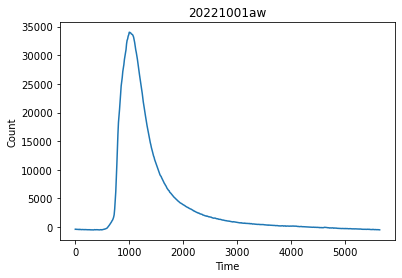

  6%|▌         | 67/1091 [00:00<00:02, 360.71it/s]

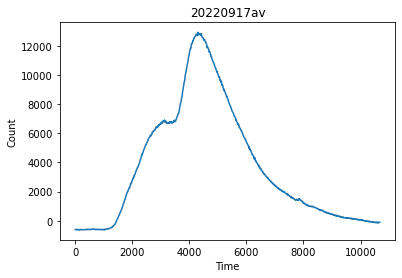

 11%|█▏        | 124/1091 [00:00<00:02, 386.88it/s]

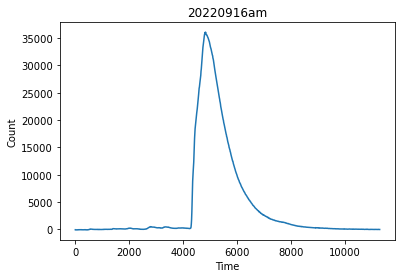

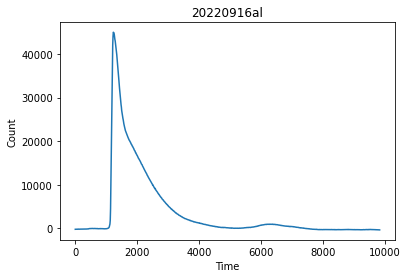

 15%|█▌        | 164/1091 [00:00<00:03, 245.39it/s]

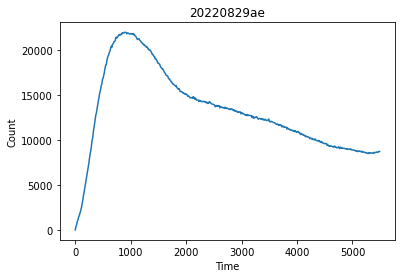

 19%|█▉        | 209/1091 [00:00<00:03, 292.57it/s]

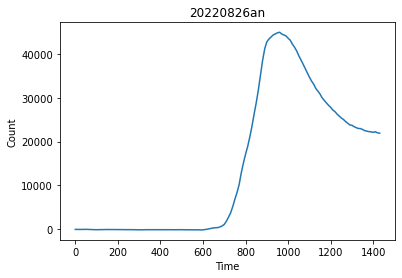

 22%|██▏       | 244/1091 [00:00<00:03, 268.42it/s]

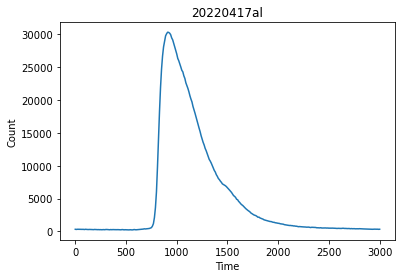

 26%|██▌       | 284/1091 [00:01<00:02, 270.15it/s]

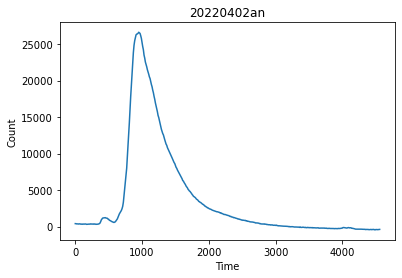

 29%|██▉       | 317/1091 [00:01<00:02, 265.41it/s]

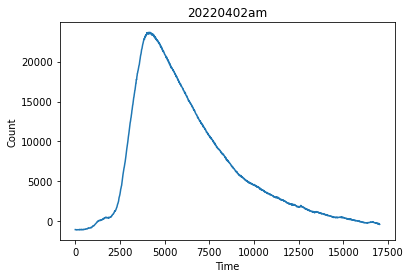

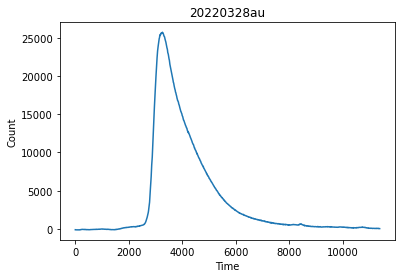

100%|██████████| 1091/1091 [00:01<00:00, 762.87it/s]


In [8]:
try:
    anomcsv = pd.read_csv('anomalies.csv')
except FileNotFoundError:
    anomcsv = pd.DataFrame(columns=norminfo.columns)
    
# Plotting anomalies
for i, recondata in enumerate(tqdm(datanorm)):
    recondata_class = int(np.round(recondata[0]))
    if anomalies[i] == True:
        plt.plot(np.arange(0, len(datanorm[i][datanorm[i] != 0]))*10, datanorm[i][datanorm[i] != 0])
        plt.xlabel('Time')
        plt.ylabel('Count')
        plt.title(f"{idsnorm[i]}")
        plt.show()
        
        # Saving anomalies to CSV
        anomcsv = pd.concat([anomcsv, norminfo.iloc[[i]]], ignore_index=True)
        anomcsv.to_csv('anomalies.csv', index=False)

# Saving anomaly flares to anomaly_flares
os.makedirs('anomaly_flares', exist_ok=True)
anomalinfo = pd.read_csv('anomalies.csv')
anomids = [i for i in anomalinfo['identifier']]
for i in anomids:
    flare = pd.read_csv('flares/' + f'{i}' + '.csv')
    flare.to_csv('anomaly_flares/' + f'{i}' + '.csv', index=False)

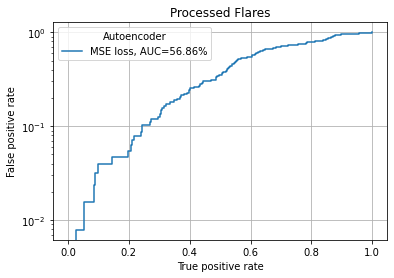

In [9]:
# ROC and AUC of Processed Flares
fpr, tpr, thresholds = roc_curve(labelsnorm, reconerror)

plt.figure()
plt.plot(tpr, fpr, label=f"MSE loss, AUC={auc(fpr, tpr)*100:.2f}%")
plt.semilogy()
plt.legend(title="Autoencoder")
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.grid()
plt.title("Processed Flares")
plt.show()

In [10]:
# Anomaly Detection of Pre-Processed Flares
norminfo = pd.read_csv('allflares_preprocessed.csv')
idsnorm = [i for i in norminfo['identifier']]
peak_count = [int(count) for count in norminfo['peak_count']]

datanorm = []
labelsnorm = []

for i in idsnorm:
    tod = pd.read_csv('flares/' + f'{i}' + '.csv')
    datanorm.append(list(tod['Counts']))
    
for index in range(len(norminfo)):
    if str(norminfo['flare_type'][index]) == 'A':
        labelsnorm.append(0)
    else:
        labelsnorm.append(1)
        continue
datanorm = pad_sequences(datanorm, padding='post', dtype=float, maxlen=1999)   # the padding is to adjust the shape of the np arrays

datanorm_deriv = [ (datanorm[i][1:] - datanorm[i][:-1]) for i in range(len(datanorm)) ] 
datanorm_deriv = pad_sequences(datanorm_deriv, padding='post', dtype=float)
print(datanorm.shape)
print(datanorm_deriv.shape)
print(type(datanorm_deriv[0,0]))

(8045, 1999)
(8045, 1998)
<class 'numpy.float64'>


In [11]:
datanorm_expanded = np.expand_dims(datanorm, axis=-1)
datanorm_deriv_expanded = np.expand_dims(datanorm_deriv, axis=-1)

# Use the autoencoder to reconstruct the inputs based on model data
recondata = autoencoder.predict([datanorm_expanded, datanorm_deriv_expanded])

# Compute reconstruction errors
reconerror = np.mean(np.square(recondata - datanorm) , axis=1)

# Anomaly detection based on reconstruction error
threshold = (np.mean(reconerror) + (3 * np.std(reconerror))) 
anomalies = reconerror > threshold

print(f'Size of Testing Data = {anomalies.size}')
print(f'Number of Anomalies Detected = {np.sum(anomalies)}')
print(f'Percent Anomalies = {(np.sum(anomalies) / anomalies.size)}')

252/252 [==============================] - 2s 6ms/step
Size of Testing Data = 8045
Number of Anomalies Detected = 46
Percent Anomalies = 0.005717837165941579


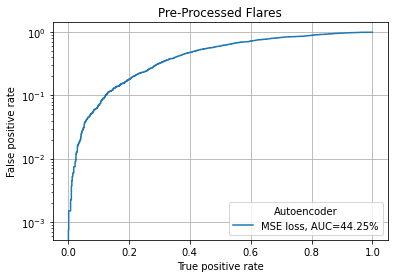

In [12]:
# ROC and AUC of Pre-Processed Flares
fpr, tpr, thresholds = roc_curve(labelsnorm, reconerror)

plt.figure()
plt.plot(tpr, fpr, label=f"MSE loss, AUC={auc(fpr, tpr)*100:.2f}%")
plt.semilogy()
plt.legend(title="Autoencoder")
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.grid()
plt.title("Pre-Processed Flares")
plt.show()